Домашнее задание
<br>Построение и настройка модели случайного леса. Визуализация важности признаков.
<br>Цель: использовать следующий датасет: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In [1]:
import pandas as pd
import numpy as np
import os, re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Preprocessing

In [7]:
data_path = '/Users/katush/Documents/Otus/ML/L12-Ensembles/Car Evaluation Data Set/'
os.listdir(data_path)

['.DS_Store', 'car.data', 'car.names', 'car.c45-names']

In [49]:
data = pd.read_csv(data_path+'car.data', header=None)
data.columns= ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [50]:
for i in data.columns:
    print(i, data[i].unique())

buying ['vhigh' 'high' 'med' 'low']
maint ['vhigh' 'high' 'med' 'low']
doors ['2' '3' '4' '5more']
persons ['2' '4' 'more']
lug_boot ['small' 'med' 'big']
safety ['low' 'med' 'high']
class ['unacc' 'acc' 'vgood' 'good']


In [93]:
data_map = data.copy()
data_ohe = data.copy()

In [94]:
d1 = {'vhigh':3, 'high':2, 'med':1, 'low':0}
d2 = {'small':0, 'med':1, 'big':2}
d3 = {'low':0, 'med':1, 'high':2}
d4 = {'unacc':0, 'acc':1, 'vgood':2, 'good':3}

data_map.buying = data_map.buying.map(d1)
data_map.maint = data_map.maint.map(d1)
data_map.lug_boot = data_map.lug_boot.map(d2)
data_map.safety = data_map.safety.map(d3)
data_map['class'] = data_map['class'].map(d4)
data_map.doors = data_map.doors.replace('5more', 5).astype(int)
data_map.persons = data_map.persons.replace('more', 5).astype(int)

data_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying      1728 non-null int64
maint       1728 non-null int64
doors       1728 non-null int64
persons     1728 non-null int64
lug_boot    1728 non-null int64
safety      1728 non-null int64
class       1728 non-null int64
dtypes: int64(7)
memory usage: 94.6 KB


In [98]:
for i in data_ohe.columns[:-1]:
    temp = pd.get_dummies(data_ohe[i], drop_first=True, prefix=i)
    data_ohe = pd.concat([data_ohe.drop(i, axis=1), temp], axis=1)
data_ohe['class'] = data_ohe['class'].map(d4)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
class             1728 non-null int64
buying_low        1728 non-null uint8
buying_med        1728 non-null uint8
buying_vhigh      1728 non-null uint8
maint_low         1728 non-null uint8
maint_med         1728 non-null uint8
maint_vhigh       1728 non-null uint8
doors_3           1728 non-null uint8
doors_4           1728 non-null uint8
doors_5more       1728 non-null uint8
persons_4         1728 non-null uint8
persons_more      1728 non-null uint8
lug_boot_med      1728 non-null uint8
lug_boot_small    1728 non-null uint8
safety_low        1728 non-null uint8
safety_med        1728 non-null uint8
dtypes: int64(1), uint8(15)
memory usage: 38.9 KB


# Model selection

In [128]:
def rndf_pred(data):
    X = data.drop('class', axis=1)
    y = data['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    rndfclf = RandomForestClassifier(random_state=1)
    
    params = {'n_estimators': [1, 10, 100, 200]}
    
    grid = GridSearchCV(estimator=rndfclf, param_grid=params, cv=5)
    grid = grid.fit(X_train, y_train)
    
    print(grid.best_estimator_)

In [129]:
print('data_map')
rndf_pred(data_map)
print('data_ohe')
rndf_pred(data_ohe)

data_map
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
data_ohe
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


Model on mapped data shows better results at 200 estimators, meanwhile model on OHE data - 100 estimators.

In [134]:
def rndf_pred(data, n_estimators):
    X = data.drop('class', axis=1)
    y = data['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    rndfclf = RandomForestClassifier(random_state=1, n_estimators=n_estimators)
    rndfclf.fit(X_train, y_train)
    y_pred = rndfclf.predict(X_test)

    print(classification_report(y_test, y_pred))
    return rndfclf

In [135]:
rndfclf_map = rndf_pred(data_map, n_estimators=200)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       0.98      0.91      0.94       103
           2       0.90      0.90      0.90        20
           3       0.62      0.87      0.72        15

    accuracy                           0.97       432
   macro avg       0.87      0.92      0.89       432
weighted avg       0.97      0.97      0.97       432



In [136]:
rndfclf_ohe = rndf_pred(data_ohe, n_estimators=100)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       294
           1       0.82      0.79      0.80       103
           2       0.90      0.45      0.60        20
           3       0.36      0.33      0.34        15

    accuracy                           0.90       432
   macro avg       0.76      0.64      0.68       432
weighted avg       0.89      0.90      0.89       432



Mapping integers to object columns performes better results in terms of f1-score and accuracy.

# Feature importances

In [139]:
data_map.columns[:-1]

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')

In [140]:
for name, score in zip(data_map.columns[:-1], rndfclf_map.feature_importances_):
    print(name, score)

buying 0.15479788165468253
maint 0.14635225938433816
doors 0.06516365665987521
persons 0.23566902352674565
lug_boot 0.0906703964772284
safety 0.30734678229713003


<BarContainer object of 6 artists>

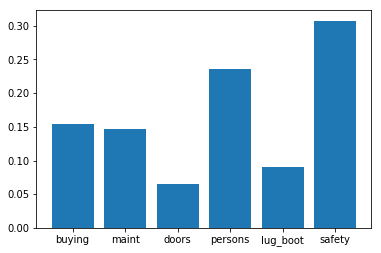

In [146]:
plt.bar(data_map.columns[:-1], rndfclf_map.feature_importances_)